## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.. <br><br>

<br>


## 0 Imports


### 0.0 Choix du modèle


In [1]:
tested_models = ['VGG', # VGG_16
                 'EfficientNetV2L', 'NASNetLarge', 'EfficientNetV2S', 'InceptionResNetV2', # top 4 sota models / keras.appli
                 'NASNetMobile', 'MobileNetV2'] # les 2 + légers


model_name = 'VGG'


if model_name == 'VGG':
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.applications.vgg16 import preprocess_input
    size_wh = 224
    base_model = VGG16()
    # top 2 layers

if model_name == 'EfficientNetV2L':
    from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
    from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
    size_wh = 480
    base_model = EfficientNetV2L()

if model_name == 'NASNetLarge':
    from tensorflow.keras.applications.nasnet import NASNetLarge
    from tensorflow.keras.applications.nasnet import preprocess_input
    size_wh = 331
    base_model = NASNetLarge()

if model_name == 'EfficientNetV2S':
    from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
    from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
    size_wh = 384
    base_model = EfficientNetV2S()

if model_name == 'InceptionResNetV2':
    from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
    size_wh = 299
    base_model = InceptionResNetV2()

if model_name == 'NASNetMobile':
    from tensorflow.keras.applications.nasnet import NASNetMobile
    from tensorflow.keras.applications.nasnet import preprocess_input
    size_wh = 224
    base_model = NASNetMobile()
    # top 25 layers ? (+- 5)

if model_name == 'MobileNetV2':
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    size_wh = 224
    base_model = MobileNetV2()
    # top 2 layers


print('\n', f'Modèle choisi : {model_name}')

target_size=(size_wh, size_wh)



# top 3

# InceptionResNetV2	215	80.3%	95.3%
# efficientnet_v2 ?
# NASNetLarge	343	82.5%	96.0%

# + leger :
# MobileNetV2	14	71.3%	90.1%
# NASNetMobile	23	74.4%	91.9%


2024-04-06 20:58:25.959152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-06 20:58:28.173330: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



 Modèle choisi : VGG


### 0.1 Librairies, réglages


In [2]:
# paths, folders/files
import os, sys, random, re
from os import listdir
from glob import glob
from zipfile import ZipFile
import time
import json

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image
from optuna.visualization import plot_optimization_history
from tensorflow.keras.utils import plot_model
try:
    import cv2 # Pas de les répos
except:
    print('Installing opencv...')
    %pip install opencv-python # activate env first (ok, always activated first by kernel)
    import cv2
    print('done')

from sklearn import metrics as sk_metrics

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer





import tensorflow as tf
print('Tensorflow version ' + tf.__version__)

from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
import optuna
%pip install optuna-integration
from optuna_integration import TFKerasPruningCallback
from functools import partial

# tracking
from mlflow import MlflowClient
import mlflow.keras


# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks
os.environ['MLFLOW_TRACKING_URI'] = './'
# Utilisable seulement en local ?
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

import pickle
from keras.models import save_model as save_model_h5


print('\nPython version ' + sys.version)
print('Seaborn version ' + sns.__version__)
print('Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0')
print('Keras version ' + tf.keras.__version__)
# no autolog...

# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


Tensorflow version 2.12.0
Note: you may need to restart the kernel to use updated packages.

Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
Seaborn version 0.12.2
Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0
Keras version 2.12.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Variables globales


In [3]:
nb_classes = 20      # min 2, max 120 (theorique, en pratique les dataframes préparés sont : 3, 4, 5, 10)
                    # possible d'en creer + en utilisant le ntbk 1

show_tsne = False
sample_ratio = 1
nb_layers_trainable = 2


norm = False

test_size = 0.15    # same for validation

alea = 42   # pour fixer les ttsplits et tjs travailler sur les mm datasets
# En revanche l'initialisation des poids des modèles restera aléatoire,
# pour pouvoir comparer les resultats sur +ieurs runs.

nb_runs = 1     # 2-3 le matin, 50 le soir
                # avec keras-tuner / optuna, plus besoin de runs multiples..
                # à la place on a des trials multiples !

n_trials = 1    # 10

for i in [3, 4, 5, 10]:
    try:
        pickle_path_model = f'./pickle/perso/best_{i}/ze_model.pkl'
        pickle_path_accuracy = f'./pickle/perso/best_{i}/best_accuracy_val.pkl'
        pickle_path_params = f'./pickle/perso/best_{i}/best_params.pkl'

        best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
        best_parameters = pickle.load(open(pickle_path_params, 'rb'))
        # Parse the JSON string into a dictionary
        # best_parameters = json.loads(best_parameters_string)
    except:
        best_acc = 1 / nb_classes   # proba prediction random, baseline
        best_parameters = {}

    print('\n', f'Best accuracy val on {i} classes :')
    print(best_acc, '\n')
    print('Best_parameters :', '\n')
    pprint(best_parameters)

print('\n', f'Nb de classes prises en compte ds ce ntbk : {nb_classes}')
print(f'Normalization : {norm}')


pickle_path_model = f'./pickle/perso/best_{nb_classes}/ze_model.pkl'
pickle_path_accuracy = f'./pickle/perso/best_{nb_classes}/best_accuracy_val.pkl'
pickle_path_params = f'./pickle/perso/best_{nb_classes}/best_params.pkl'

try:
    best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
    best_parameters = pickle.load(open(pickle_path_params, 'rb'))
    epochs = best_parameters['nb epochs']
    if 'no_norm' in best_parameters['preprocessing']:
        norm = False

except:
    best_acc = 1 / nb_classes   # proba prediction random, baseline
    best_parameters = {}
    epochs = 15


val_acc_ref = 0

features_to_test = ['resized', 'expo', 'contraste', 'denoised_g', 'denoised_bi', 'denoised_nl',
                    'preprocess_complet']

all_features_to_test = ['photo_path'] + features_to_test

try:
    feature = best_parameters['feature']
    if feature == 'originale, photo_path':
        feature = 'photo_path'
except:
    feature = 'photo_path'



 Best accuracy val on 3 classes :
0.7692307829856873 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '3_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

 Best accuracy val on 4 classes :
0.6235294342041016 

Best_parameters : 

{'dim images': '128 x 128 x 3',
 'feature': 'expo',
 'model': 'V1',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'size val test sets': 0.15,
 'target': '4_classes'}

 Best accuracy val on 5 classes :
0.6666666865348816 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 16,
 'conv_2_units': 8,
 'dense_units': 224,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'si

### 0.3 Fonctions


### 0.4 Metriques


In [4]:
# J'utiliserai tjs les noms anglais des métriques ici,
# pour éviter la confusion précision (fr) != precision (en),
# et pour simplement garder les noms des fonctions importées depuis tf.keras.metrics

# Nous sommes dans un cas de classification "classique", 1 classe prédite.
# Une première métrique simple et intuitive est donc l'accuracy :
# nb de prédictions correctes / nb total de prédictions.
# Cette métrique nous suffit déjà pour comparer et optimiser nos modèles.

# Si l'on souhaite étudier + en détail les prédictions des modèles, on utilisera
# la precison et le recall

# Precison (TP / (TP + FP)) :
# Une précision élevée signifie que si une classe est prédite par le modèle,
# alors il y a une forte probabilité (égale à la precision)
# que le chien appartienne en effet à cette classe.

# Recall (TP / (TP + FN)) :
# pour évaluer la capacité des modèles à identifier toutes les instances positives.
# Exemple : Si notre precision est égale à 1, c'est parfais, cela signifie que
# pour une une classe au moins, toutes les valeurs prédites par le modèle sont correctes.
# Cependant, il est possible que cela ne concerne que très peu de cas (mettons, 1 ou 2 prédictions)
# et qu'à côté de cela le modèle a pu faire des milliers de prédictions incorrectes,
# la precision seule ne nous le dit pas.

# Comme l'amélioration de la precision se fait svt au détriment du recall, en pratique
# on combine souvent les 2 avec le f1score (= moyenne harmonique)
# (2 x precision x recall) / (precision + recall)
# qui nous donne directement une idée du compromis precision / recall

# petit souci : le f1score et keras, c'est tout une histoire...
# Dans les versions récentes (depuis la 2.15.0 il me semble), le f1score est supprimé
# du module metrics, tt comme precision() et recall().
# Contrairement à l'accuracy, qui est calculée par époque lors du fit,
# le f1score (&precision, recall) étaient calculés par batch par défaut,
# nécessitant la mise en place d'une fonction de callback pour avoir des métriques
# cohérentes avec l'accuracy, et interprétables.

# En +, conda a bcp de mal à résoudre un env avec ces versions,
# incompatibles avec les requirements d'autres packages dans l'env.

# Dans les versions + anciennes de keras, le f1score était dans un autre module, "addons",
# mais ce moule est désormais déprécié.

# Solutions :

# - On pourrait utiliser addons qd mm, mais pas pour longtemps.
# - définir un f1score custom
# Pas évident car tensorflow est très pointilleux sur les types d'objets qu'il accepte.
# Exemple : cette fonction est construite en utilisant 2 fonctions tf.keras,
# pourtant elle renvoit une erreur si on tente de l'utiliser parce que le type retourné est
# un float.

def custom_f1score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = (2*precision*recall) / (precision + recall)

    return f1

# Autre solution possible, utiliser le f1score de sk-learn. Là encore cela demande des ajustements.

# -> Utilisons simplement l'accuracy pour entrainer les modeles,
# nous reviendrons aux métriques + fines pour l'analyse des prédictions
# (tables de confusion, etc...)

metrics=[
    'Accuracy',
]


### 0.4 Data


In [5]:
data = pd.read_csv(f'./data/data_{nb_classes}_classes.csv', sep=',')


def stratified_sample(data, target, frac):
    # Group the data by the target variable
    grouped = data.groupby(target, group_keys=False, as_index=False)  # ss_index=False to keep breed column
    # Sample from each group
    sampled_data = grouped.apply(lambda x: x.sample(frac=frac), include_groups=True) #  deprecated
    # Reset the index
    sampled_data.reset_index(drop=True, inplace=True)
    return sampled_data


data = stratified_sample(data, 'breed', sample_ratio)


print(data.shape)
data.head()

# to avoid deprecated method : loop on data['breed'].uniques instead ?


(4244, 2)


/tmp/ipykernel_283559/2626548867.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = grouped.apply(lambda x: x.sample(frac=frac), include_groups=True) #  deprecated


,photo_path,breed
0,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound
1,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound
2,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound
3,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound
4,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound


### 0.5 Etude de faisabilité (sort of)


### base model


In [6]:
print(base_model.summary())


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Save the model architecture to a file in order to vizualize its architecture using netron
# save_model_h5(base_model, './data/current_model_architecture.h5')


In [8]:
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# Visualize the model architecture
# manque pydot et graphviz

# plot_model(base_model, to_file='inception_resnet_v2.png', show_shapes=True)


In [10]:
# model_block_1 = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# print(model_block_1.summary())


In [11]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# modèle

def feature_extraction():
    images_features = []

    for image_file in data['photo_path']:
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    # images_features.shape

    # Reshape images to flatten them into vectors
    flattened_images = images_features.reshape(images_features.shape[0], -1)
    print(flattened_images.shape)

    # Normalize the data
    scaler = StandardScaler()
    normalized_images = scaler.fit_transform(flattened_images)

    return normalized_images


In [12]:
if show_tsne:
    normalized_images = feature_extraction()


### 0.6 Réduction dim


In [13]:
# PCA

if show_tsne:
    def features_through_PCA(normalized_images=normalized_images, plot=True):

        print(normalized_images.shape) # same as flattened_images

        pca = decomposition.PCA(n_components=0.99)
        feat_pca= pca.fit_transform(normalized_images)

        print(feat_pca.shape)

        if plot:
            # Plot explained variance ratio
            plt.figure(figsize=(8, 6))
            plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative Explained Variance Ratio')
            plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
            plt.grid(True)
            plt.show()

        return feat_pca


    feat_pca = features_through_PCA()

# dimention divisée par 200 (presque), en conservant 99% de la variance !


In [14]:
# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.7 tsne


In [15]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,target
0,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0


,photo_path,breed,target
4243,./data/cleaned_data/0_format/-tibetan_terrier/...,tibetan_terrier,19


In [16]:
# t-sne

if show_tsne:
    def tsne_graph(feat_pca=feat_pca, dark=True):
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
        X_tsne = tsne.fit_transform(feat_pca)

        df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
        df_tsne["class"] = data["target"]

        # Set the background style to dark
        if dark == True:
            plt.style.use('dark_background')

        plt.figure(figsize=(8,5))
        sns.scatterplot(
            x="tsne1", y="tsne2",
            hue="class",
            palette=sns.color_palette('tab20', n_colors=nb_classes), s=50, alpha=0.7,
            data=df_tsne,
            # legend="brief"
            )

        # plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
        # plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
        # plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
        # plt.legend(prop={'size': 14})

        plt.axis('off')  # Deactivate ticks
        plt.legend().remove()  # Remove legend
        plt.show()


    tsne_graph()

# Il est fort !


## images mal classées


In [17]:
# tsne sur les vrai classes, training + val set uniquement

X_feature = []

for image_file in data['photo_path']:
    image = load_img(image_file, target_size=target_size)
    image = img_to_array(image)
    # image = np.expand_dims(image, axis=0)
    # image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    X_feature.append(image)

X_feature = np.asarray(X_feature)
print(X_feature.shape)

# X_feature = feature_to_array(feature=feature, norm=norm, expand=False, predict=False) # model
# X_feature = feature_to_array(feature=feature, norm=norm, expand=True, predict=True) # -> pca tsne
y_target = np.asarray(data["target"])

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=test_size,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train)

y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_val_ohe = tf.keras.utils.to_categorical(y_val)
y_test_ohe = tf.keras.utils.to_categorical(y_test)


# Fit model again ?
# best_model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32, verbose=0)

# environ 10G de memoire pour 20 classes...


(4244, 224, 224, 3)


In [18]:
# Récupérer la sortie de ce réseau
x = model.output
# Compléter le modèle
predictions_vgg = Dense(nb_classes, activation='softmax')(x)

# Définir le nouveau modèle
whole_model = Model(inputs=model.input, outputs=predictions_vgg)

print(whole_model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### preds


In [19]:
# predict (on a sample of the dataset if > 20-30 classes) + whole test set

# predicted_classes = model.predict_classes(X_test) # deprecated

def make_predictions(whole_model=whole_model, X_feature=X_feature):
    time_start = time.time()
    predictions_all = whole_model.predict(X_feature)
    time_end = time.time()
    time_predict_moy = (time_end - time_start) / len(X_feature)

    predicted_classes_all = np.argmax(predictions_all, axis=1)

    return predictions_all, predicted_classes_all, time_predict_moy


# predictions_all, predicted_classes_all, _ = make_predictions(whole_model, X_feature)
# predictions_test, predicted_classes_test, time_predict_moy = make_predictions(whole_model, X_test)


In [20]:
# data['predictions'] = predicted_classes_all
data.head()


,photo_path,breed,target
0,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0
1,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0
2,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0
3,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0
4,./data/cleaned_data/0_format/-afghan_hound/n02...,afghan_hound,0


In [21]:
print(data.shape[0])
# print(data.loc[~(data['predictions'] == data['target'])].shape[0])

# ??


4244


In [22]:
def count_misclassified(y_test, predicted_classes_test):

    misclassified_in_test = 0
    print(len(y_test))

    for i in range(len(y_test)):
        if y_test[i] != predicted_classes_test[i]:
            misclassified_in_test += 1

    print(misclassified_in_test)


# count_misclassified(y_test=y_test, predicted_classes_test=predicted_classes_test)

# not yet


### refit


In [23]:
def save_model(model, params, history):
    global pickle_path_model
    global pickle_path_params
    global pickle_path_history

    with open(pickle_path_model, 'wb') as f:
        pickle.dump(model, f)
    # also save params
    with open(pickle_path_params, 'wb') as f:
        pickle.dump(params, f)
    # and history
    with open(pickle_path_history, 'wb') as f:
        pickle.dump(history, f)


def update_params(params, new_params):
    global pickle_path_params

    params.update(new_params)

    with open(pickle_path_params, 'wb') as f:
        pickle.dump(params, f)


In [24]:
# early stop direct !

pickle_path_model = f'./pickle/pretrained/{nb_classes}_classes/{model_name}_{nb_layers_trainable}_lay_{sample_ratio*100}_pc_model.pkl'
pickle_path_params = f'./pickle/pretrained/{nb_classes}_classes/{model_name}_{nb_layers_trainable}_lay_{sample_ratio*100}_pc_params.pkl'
pickle_path_history = f'./pickle/pretrained/{nb_classes}_classes/{model_name}_{nb_layers_trainable}_lay_{sample_ratio*100}_pc_history.pkl'


try: # retrained model already exists

    whole_model = pickle.load(open(pickle_path_model, 'rb'))
    # print(whole_model.summary(), '\n')
    params = pickle.load(open(pickle_path_params, 'rb'))
    pprint(params)
    history = pickle.load(open(pickle_path_history, 'rb'))


except: # we need to retrain it
    depth = 0
    for layer in model.layers:
        layer.trainable = True
        depth += 1 # to check parameter

    for layer in model.layers[:-nb_layers_trainable]: # retrain all except top 50 (par exemple)
        layer.trainable = False
        # print(whole_model.summary())

    epochs = 10

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1) #, restore_best_weights=True)

    # compilation du modèle (after setting trainable layers)
    whole_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Train the model with the early stopping callback

    time_start = time.time()
    history = whole_model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32, verbose=1,
                            validation_data=(X_val, y_val_ohe), callbacks=[early_stopping])
    time_end = time.time()
    time_fit = time_end - time_start

    params = {
        "model": f'{model_name}',
        'depth': f'{depth}',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'layers fine tuned': f'{nb_layers_trainable}',
        'trained on': f'{int(sample_ratio*100)}% data',
        'time_fit': f'{int(time_fit)} s',
    }

    save_model(model=whole_model, params=params, history=history)


Epoch 1/10


96/96 [==============================] - 642s 7s/step - loss: 6.1643 - accuracy: 0.5498 - val_loss: 1.1287 - val_accuracy: 0.7232
Epoch 2/10
96/96 [==============================] - 682s 7s/step - loss: 1.2563 - accuracy: 0.8222 - val_loss: 2.5201 - val_accuracy: 0.6679


### saved


In [25]:
# save_model(model=whole_model, params=params, history=history)

# pprint(history.history)

# par rapport a vgg, presente 2 problemes :

# donnees en entrees 1.8x + lourdes (photos 299x299, pour 224x224 pour vgg)
# (mais on peut redefinir un input + petit... mais ca obligerai a tt reentrainer, impossible)

# bcp, bcp + de couches et donc de poids. Pas le choix, obligé de se limiter a du fine tuning partiel ici.


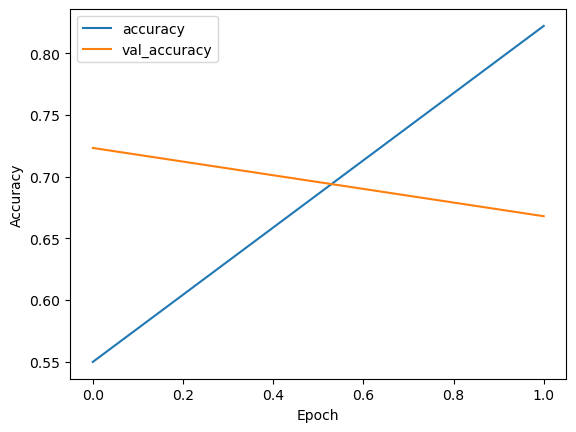

In [26]:
# almost there

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history(history)


### new preds


In [27]:
predictions_test, predicted_classes_test, time_predict_moy = make_predictions(whole_model, X_test)


20/20 [==============================] - 93s 5s/step


In [28]:
print(data.shape[0])


4244


In [29]:
misclassified_in_test = 0
print(len(y_test))

for i in range(len(y_test)):
    if y_test[i] != predicted_classes_test[i]:
        misclassified_in_test += 1

print(misclassified_in_test)

# mmm


637
220


In [30]:
new_params = {
    # add model size ?
    'time_predict_moy': f'{time_predict_moy:.2f} s',
    'predict on': f'{int(sample_ratio*100)}% data',
    'misclass_test': f'{misclassified_in_test} / {len(y_test)}',
    'accuracy_test': f'{1 - (misclassified_in_test / len(y_test)):.2f}',
}

update_params(params, new_params)
pprint(params)


{'accuracy_test': '0.65',
 'depth': '22',
 'dim images': '224 x 224 x 3',
 'layers fine tuned': '2',
 'misclass_test': '220 / 637',
 'model': 'VGG',
 'predict on': '100% data',
 'time_fit': '1343 s',
 'time_predict_moy': '0.22 s',
 'trained on': '100% data'}


### nb layers retrained : comparaison


In [31]:
# f'./pickle/pretrained/{nb_classes}_classes/{base_model_name}_{nb_layers_trainable}_lay_{sample_ratio*100}_pc_params.pkl'

def check_parameters(path=f'./pickle/pretrained/{nb_classes}_classes'):
    """List content of the Image folder"""

    data_path = glob(path+f'/{model_name}*params.pkl')
    list_files = [file for file in data_path]
    print(len(list_files))
    # pprint(list_files)

    dfs = []

    for file in list_files:
         with open(file, 'rb') as f:
            params_dict = pickle.load(f)
            df = pd.DataFrame.from_dict(params_dict, orient='index').T
            dfs.append(df)

    if dfs:
        result_df = pd.concat(dfs, ignore_index=True)
        return result_df
    else:
        print("No pickled dictionaries found.")
        return None

result_df = check_parameters()

if result_df is not None:
    # Sort the DataFrame by accuracy in descending order (higher is better)
    result_df.sort_values(by='accuracy_test', ascending=False, inplace=True)

    display(result_df.head(60))  # Display the concatenated DataFrame


5


,model,depth,dim images,layers fine tuned,trained on,time_fit,time_predict_moy,predict on,misclass_test,accuracy_test,retrained layers,nb epochs,misclass_train,accuracy_train
4,VGG_16_20_classes,NaN,224 x 224 x 3,NaN,complete data,30-40 min ?,0.132703,80% data,17 / 510,0.9666666666666667,all,5,100 / 3396,0.9705535924617197
1,VGG,22,224 x 224 x 3,3,100% data,4044 s,0.22 s,100% data,154 / 637,0.76,NaN,NaN,NaN,NaN
2,VGG,22,224 x 224 x 3,4,100% data,1343 s,0.22 s,100% data,177 / 637,0.72,NaN,NaN,NaN,NaN
3,VGG,22,224 x 224 x 3,2,100% data,1343 s,0.22 s,100% data,220 / 637,0.65,NaN,NaN,NaN,NaN
0,VGG,22,224 x 224 x 3,8,100% data,5279 s,0.22 s,100% data,573 / 637,0.10,NaN,NaN,NaN,NaN


### comparaison autres modeles


In [32]:
#

def compare_models(path=f'./pickle/pretrained/{nb_classes}_classes'):
    """List content of the Image folder"""

    data_path = glob(path+f'/*params.pkl')
    list_files = [file for file in data_path]
    print(len(list_files))
    # pprint(list_files)

    dfs = []

    for file in list_files:
         with open(file, 'rb') as f:
            params_dict = pickle.load(f)
            df = pd.DataFrame.from_dict(params_dict, orient='index').T
            dfs.append(df)

    if dfs:
        result_df = pd.concat(dfs, ignore_index=True)
        return result_df
    else:
        print("No pickled dictionaries found.")
        return None

result_df = compare_models()

if result_df is not None:
    # Sort the DataFrame by accuracy in descending order (higher is better)
    result_df.sort_values(by='accuracy_test', ascending=False, inplace=True)

    display(result_df.head(60))  # Display the concatenated DataFrame


20


,model,depth,dim images,layers fine tuned,trained on,time_fit,size (MB),time_predict_moy,predict on,misclass_test,accuracy_test,retrained all layers,nb epochs,misclass_train,accuracy_train,retrained layers
9,NASNetLarge_20_classes,?,331 x 331 x 3,50,30% data,1176 s,88,0.74 s,30% data,5 / 192,0.97,False,1,12 / 1275,0.99,NaN
18,VGG_16_20_classes,NaN,224 x 224 x 3,NaN,complete data,30-40 min ?,NaN,0.132703,80% data,17 / 510,0.9666666666666667,NaN,5,100 / 3396,0.9705535924617197,all
2,NASNetMobile_20_classes,770,224 x 224 x 3,25,100% data,265 s,88,0.03 s,100% data,27 / 637,0.96,False,1,193 / 4244,0.95,NaN
12,EfficientNetV2S_20_classes,?,384 x 384 x 3,top 50,40% data,695 s,88,0.16 s,40% data,9 / 255,0.96,False,1,60 / 1699,0.96,NaN
5,NASNetMobile_20_classes,770,224 x 224 x 3,10,100% data,391 s,88,0.03 s,100% data,35 / 637,0.95,False,2,168 / 4244,0.96,NaN
10,NASNetMobile_20_classes,770,224 x 224 x 3,50,100% data,295 s,88,0.03 s,100% data,47 / 637,0.93,False,1,309 / 4244,0.93,NaN
14,NASNetMobile_20_classes,770,224 x 224 x 3,20,100% data,272 s,88,0.03 s,100% data,43 / 637,0.93,False,1,182 / 4244,0.96,NaN
8,MobileNetV2_20_classes,155,224 x 224 x 3,1,100% data,325 s,NaN,0.03 s,100% data,43 / 637,0.93,NaN,NaN,NaN,NaN,NaN
1,MobileNetV2_20_classes,155,224 x 224 x 3,2,100% data,264 s,NaN,0.03 s,100% data,47 / 637,0.93,NaN,NaN,NaN,NaN,NaN
11,MobileNetV2_20_classes,155,224 x 224 x 3,3,100% data,324 s,NaN,0.03 s,100% data,49 / 637,0.92,NaN,NaN,NaN,NaN,NaN


### mat conf


In [33]:
# Si pas trop de data, sinon crash

predictions_all, predicted_classes_all, _ = make_predictions(whole_model, X_feature)
data['predictions'] = predicted_classes_all

print(data.shape[0])

misclassified_in_train = data.loc[~(data['predictions'] == data['target'])].shape[0]
print(misclassified_in_train)


 25/133 [====>.........................] - ETA: 7:43

In [ ]:
# mat conf ?

labels = data["target"]
predictions = data["predictions"]

conf_mat = sk_metrics.confusion_matrix(labels, predictions)

print(conf_mat, '\n')

print(sk_metrics.classification_report(labels, predictions))


[[238   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 199   0   0   0   0   0   1   2   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 205   0   0   0   0   0   0   0   0   1   0   0   3   0   0   0
    0   0]
 [  0   0   0 217   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1]
 [  0   0   0   0 193   0   0   1   1   0   0   0   0   0   0   0   0   0
    1   1]
 [  0   0   0   4   0 198   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 212   0   0   0   0   0   0   0   0   1   0   0
    0   0]
 [  1   1   0   0   0   0   1 208   0   0   0   0   0   0   0   0   7   0
    0   0]
 [  0   6   0   0   0   0   0   0 189   1   0   0   0   0   0   0   0   1
    0   0]
 [  0   0   0   0   0   0   0   1   0 209   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1   0   0   0 246   0   0   0   0   0   0   1
    4   0]
 [  0   0   1   0   0   0   0   0   0   0   0 194   0   0   0   0

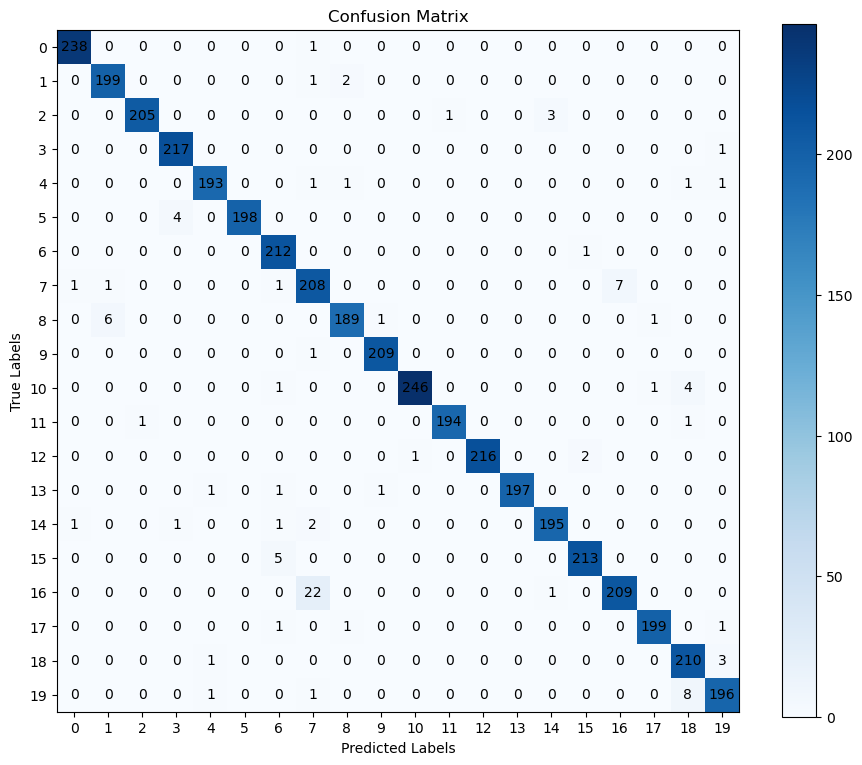

In [ ]:
# Plot the heatmap
plt.figure(figsize=(11, 9))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')

# Add annotations
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

# Customize plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick labels
plt.xticks(np.arange(conf_mat.shape[1]), np.arange(conf_mat.shape[1]))
plt.yticks(np.arange(conf_mat.shape[0]), np.arange(conf_mat.shape[0]))

plt.show()

# ok


### check misclassified


In [ ]:
print(feature)


photo_path


qq exemples de (vrais) chiens dont la race est : afghan_hound, correctement predites


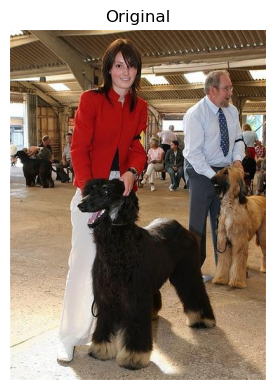

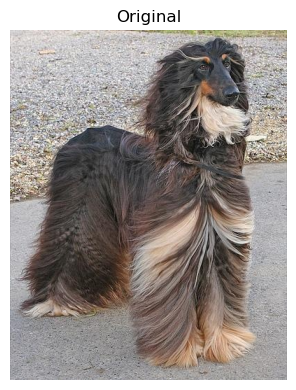

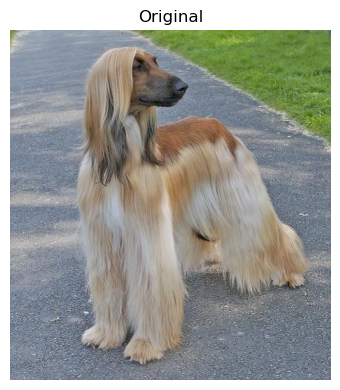

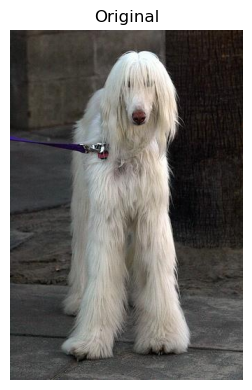

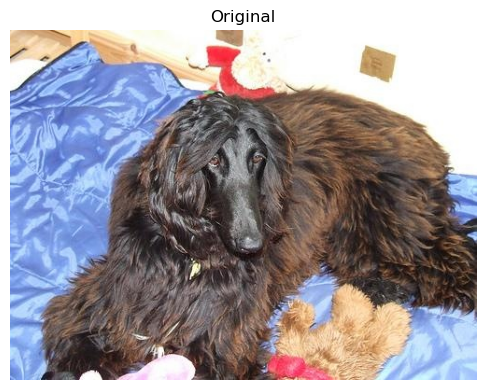

In [ ]:
# dogs breed 1 misclass as breed 2

# print a few pics from actual breed one
real_breed_0 = label_encoder.inverse_transform([0])[0]

print(f'qq exemples de (vrais) chiens dont la race est : {real_breed_0}, correctement predites')
sample_breed_0 = data.loc[(data['target'] == 0) & (data['predictions'] == 0)].sample(
    n=5).reset_index(drop=True)

# display(sample_breed_0)


for i in range(sample_breed_0.shape[0]):
    plt.figure(figsize=(6, 4))

    # Load and display image
    plt.imshow(cv2.cvtColor(cv2.imread(sample_breed_0[feature][i]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')

    plt.tight_layout()
    plt.show()

# idem breed 2

# show misclassed :
# real is 1

# real is 2

qq exemples de (vrais) chiens dont la race est : airedale, correctement predites


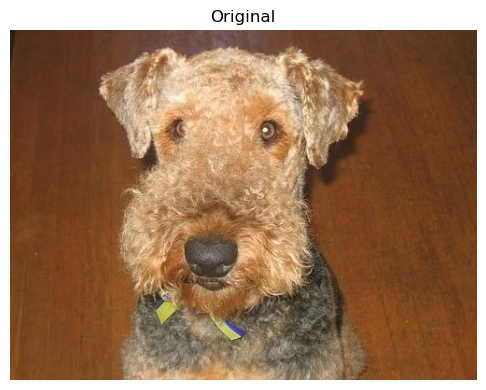

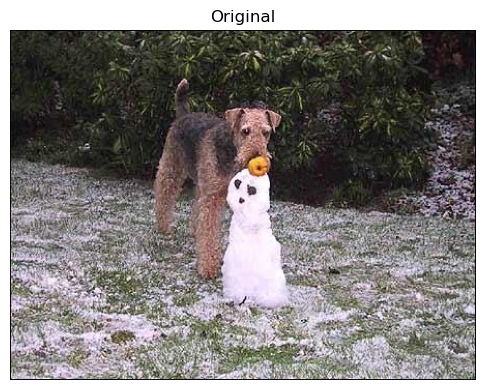

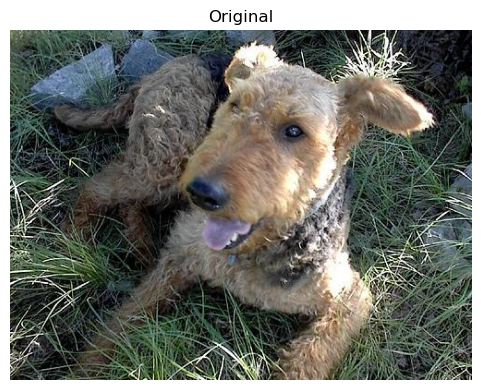

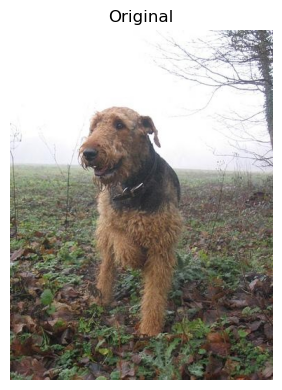

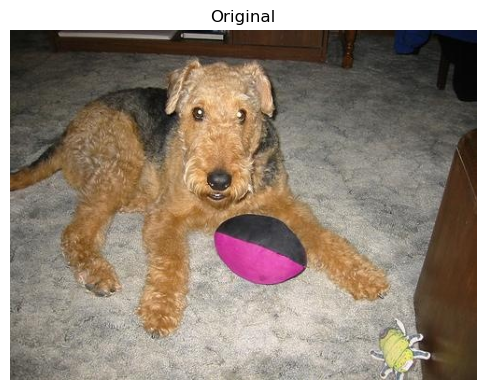

In [ ]:
real_breed_1 = label_encoder.inverse_transform([1])[0]

print(f'qq exemples de (vrais) chiens dont la race est : {real_breed_1}, correctement predites')
sample_breed_1 = data.loc[(data['target'] == 1) & (data['predictions'] == 1)].sample(
    n=5).reset_index(drop=True)

# display(sample_breed_0)


for i in range(sample_breed_1.shape[0]):
    plt.figure(figsize=(6, 4))

    # Load and display image
    plt.imshow(cv2.cvtColor(cv2.imread(sample_breed_1[feature][i]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')

    plt.tight_layout()
    plt.show()


In [ ]:
# Maintenant, voici les 0 pris par erreur pour des 1 :

sample_misclass_01 = data.loc[(data['target'] == 0) & (data['predictions'] == 1)].reset_index(drop=True)

# display(sample_breed_0)


for i in range(sample_misclass_01.shape[0]):
    plt.figure(figsize=(6, 4))

    # Load and display image
    plt.imshow(cv2.cvtColor(cv2.imread(sample_misclass_01[feature][i]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')

    plt.tight_layout()
    plt.show()

# On peut comprendre certaines erreurs :)


In [ ]:
# le contraire

sample_misclass_10 = data.loc[(data['target'] == 1) & (data['predictions'] == 0)].reset_index(drop=True)

# display(sample_breed_0)


for i in range(sample_misclass_10.shape[0]):
    plt.figure(figsize=(6, 4))

    # Load and display image
    plt.imshow(cv2.cvtColor(cv2.imread(sample_misclass_10[feature][i]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')

    plt.tight_layout()
    plt.show()


In [ ]:
# same with trainable layers ? -> ntbk 3 ?



## modele suivant


In [ ]:
# prévu au départ de tester +ieurs innovations "historiques",
# mais les modèles + récents sont si performants
# qu'on risque de ne pas voir bcp de différence,
# ils vont surtout être limités par la qté de data que la mémoire vive peut traiter.

# => testons +tôt les meilleurs modèles possibles !
# top 3 ?
